In [20]:
import pandas as pd
from itertools import product
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, recall_score
import numpy as np
import re
import matplotlib.pyplot as plt

In [21]:
def load_and_parse_data(file_path='./data/roadworks.csv', date_filter=('2024-01-01', '2025-10-04')):
    """Загрузка, парсинг geom/address, кластеризация."""
    df = pd.read_csv(file_path)
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    df['week_start'] = df['start_date'].dt.to_period('W').dt.start_time
    
    if date_filter[0]:
        df = df[(df['start_date'] >= date_filter[0]) & (df['start_date'] <= date_filter[1])]
    
    print(f"Размер датасета: {df.shape}")
    print(df.head())
    
    # Парсинг geom: WKT -> центроид (lon, lat)
    def parse_centroid(wkt):
        if pd.isna(wkt) or wkt == 'LINESTRING EMPTY':
            return np.nan, np.nan
        wkt = str(wkt)
        coords = re.findall(r'(\d+\.\d+) (\d+\.\d+)', wkt)
        if not coords:
            return np.nan, np.nan
        lons = [float(c[0]) for c in coords]
        lats = [float(c[1]) for c in coords]
        return np.mean(lons), np.mean(lats)
    
    df[['cent_lon', 'cent_lat']] = df['geom'].apply(parse_centroid).apply(pd.Series)
    df = df.dropna(subset=['cent_lon', 'cent_lat'])
    
    # Street из address
    df['street'] = df['address'].str.split(',').str[0].str.strip()
    
    # Кластеризация (участки по coords)
    coords = np.column_stack((df['cent_lon'], df['cent_lat']))
    n_clusters = min(50, len(coords) // 10)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['cluster_id'] = kmeans.fit_predict(coords)
    
    print(f"Кластеров: {df['cluster_id'].nunique()}, Уникальных улиц: {df['street'].nunique()}")
    
    actual_counts = df.groupby(['cluster_id', 'street', 'week_start']).size().reset_index(name='repair_count')
    
    # Грид
    unique_sections = df[['cluster_id', 'street']].drop_duplicates()
    min_date = df['week_start'].min()
    max_date = df['week_start'].max()
    all_weeks = pd.date_range(start=min_date, end=max_date, freq='W-MON')
    
    all_combos = []
    for _, row in unique_sections.iterrows():
        for week in all_weeks:
            all_combos.append({'cluster_id': row['cluster_id'], 'street': row['street'], 'week_start': week})
    full_grid = pd.DataFrame(all_combos)
    full_df = full_grid.merge(actual_counts, on=['cluster_id', 'street', 'week_start'], how='left')
    full_df['repair_count'] = full_df['repair_count'].fillna(0).astype(int)
    
    # Добавляем geom/address (first по группе)
    geom_map = df.groupby(['cluster_id', 'street'])['geom'].first().reset_index()
    addr_map = df.groupby(['cluster_id', 'street'])['address'].first().reset_index()
    full_df = full_df.merge(geom_map, on=['cluster_id', 'street'], how='left')
    full_df = full_df.merge(addr_map, on=['cluster_id', 'street'], how='left')
    
    print(f"Грид по участкам: {full_df.shape}")
    return full_df, df

full_df, orig_df = load_and_parse_data()

Размер датасета: (1818, 16)
                                   uuid          start_date  \
0  003d3e8e-087d-4901-8d86-e29985ea6248 2025-08-02 00:01:00   
1  00404245-adbe-4ee0-9e32-90c1ef346466 2025-08-16 00:01:00   
2  005b7020-5fbc-4890-b08e-156f2e440ac2 2025-07-14 00:01:00   
3  005ffb59-710e-454e-b781-87df46d9f46c 2025-07-01 00:01:00   
4  00620b7f-e669-4372-bcbb-a5f9ffb949e7 2025-08-02 05:00:00   

             end_date                      worker  \
0 2025-08-10 23:59:00   ООО "Профстройтехнолоджи"   
1 2025-08-22 23:59:00  ГБУ «Автомобильные дороги»   
2 2025-07-22 23:59:00           АО "Мосводоканал"   
3 2025-07-07 23:59:00           ООО «БТС Холдинг»   
4 2025-08-02 15:00:00               АНО «Москино»   

                                                work  \
0                                          Теплосеть   
1  Проведение работ по объекту: «Выполнение работ...   
2                                         Водопровод   
3  Проведение работ по объекту: «Вынос сетей водо.

In [22]:
def prepare_features(full_df, orig_df):
    """Лаги, target t+1, фичи (с чеком на столбцы)."""
    full_df = full_df.sort_values(['cluster_id', 'street', 'week_start']).copy()
    full_df['prev_count'] = full_df.groupby(['cluster_id', 'street'])['repair_count'].shift(1)
    
    full_df['next_repair_count'] = full_df.groupby(['cluster_id', 'street'])['repair_count'].shift(-1)
    full_df['has_repair'] = (full_df['next_repair_count'] > 0).astype(int)
    
    # Фичи: closed_lines
    if 'closed_lines' in orig_df.columns:
        avg_closed = orig_df.groupby(['cluster_id', 'street', 'week_start'])['closed_lines'].mean().reset_index(name='avg_closed_lines')
        full_df = full_df.merge(avg_closed, on=['cluster_id', 'street', 'week_start'], how='left')
        if 'avg_closed_lines' not in full_df.columns:
            full_df['avg_closed_lines'] = 0
        full_df['avg_closed_lines'] = full_df['avg_closed_lines'].fillna(0)
    else:
        full_df['avg_closed_lines'] = 0
    
    # Фичи: speed_reduced
    if 'speed_reduced' in orig_df.columns:
        speed_map = orig_df.groupby(['cluster_id', 'street', 'week_start'])['speed_reduced'].mean().reset_index(name='speed_reduced')
        full_df = full_df.merge(speed_map, on=['cluster_id', 'street', 'week_start'], how='left')
        if 'speed_reduced' not in full_df.columns:
            full_df['speed_reduced'] = np.nan
        full_df['low_speed_flag'] = (full_df['speed_reduced'] < 40).astype(int).fillna(0)
    else:
        full_df['low_speed_flag'] = 0
    
    full_df['is_summer'] = ((full_df['week_start'].dt.month >= 6) & (full_df['week_start'].dt.month <= 9)).astype(int)
    
    lon_map = orig_df.groupby(['cluster_id', 'street'])['cent_lon'].first().reset_index(name='cent_lon')
    lat_map = orig_df.groupby(['cluster_id', 'street'])['cent_lat'].first().reset_index(name='cent_lat')
    full_df = full_df.merge(lon_map, on=['cluster_id', 'street'], how='left')
    full_df = full_df.merge(lat_map, on=['cluster_id', 'street'], how='left')
    full_df['cent_lon'] = full_df['cent_lon'].fillna(37.6)
    full_df['cent_lat'] = full_df['cent_lat'].fillna(55.75)
    
    numeric_cols = ['avg_closed_lines', 'low_speed_flag', 'speed_reduced', 'prev_count', 'next_repair_count', 'cent_lon', 'cent_lat']
    for col in numeric_cols:
        if col in full_df.columns:
            full_df[col] = full_df[col].fillna(0)
    
    model_df = full_df.dropna(subset=['has_repair']).copy()
    model_df['high_prev'] = (model_df['prev_count'] > 1).astype(int)
    
    print("Распределение has_repair:")
    print(model_df['has_repair'].value_counts())
    print(f"\nУникальных участков: {model_df[['cluster_id', 'street']].nunique()}")
    print("\nПервые строки model_df:")
    print(model_df.head())
    print("\nNaN в model_df:")
    print(model_df.isna().sum())
    
    # Summary
    section_summary = model_df.groupby(['cluster_id', 'street'])['has_repair'].agg(
        total_weeks='count', repair_weeks='sum', repair_rate='mean'
    ).round(4).sort_values('repair_rate', ascending=False).head(10)
    print("\nTop-10 участков по риску:")
    print(section_summary)
    
    return model_df, section_summary, full_df

model_df, summary_sections, full_df = prepare_features(full_df, orig_df)

Распределение has_repair:
has_repair
0    113753
1      1579
Name: count, dtype: int64

Уникальных участков: cluster_id      50
street        1364
dtype: int64

Первые строки model_df:
   cluster_id                       street week_start  repair_count  \
0           0  -  ул. Чаплыгина от д.35/17 2024-01-15             0   
1           0  -  ул. Чаплыгина от д.35/17 2024-01-22             0   
2           0  -  ул. Чаплыгина от д.35/17 2024-01-29             0   
3           0  -  ул. Чаплыгина от д.35/17 2024-02-05             0   
4           0  -  ул. Чаплыгина от д.35/17 2024-02-12             0   

                                                geom  \
0  LINESTRING (37.648707 55.76237, 37.648811 55.7...   
1  LINESTRING (37.648707 55.76237, 37.648811 55.7...   
2  LINESTRING (37.648707 55.76237, 37.648811 55.7...   
3  LINESTRING (37.648707 55.76237, 37.648811 55.7...   
4  LINESTRING (37.648707 55.76237, 37.648811 55.7...   

                                             addres

In [39]:
from sklearn.metrics import classification_report


def train_and_evaluate(model_df):
    """Обучение с time-split (финальный чек NaN)."""
    cols = ['prev_count', 'high_prev', 'avg_closed_lines', 'low_speed_flag', 'is_summer', 'cent_lon', 'cent_lat']
    available_cols = [col for col in cols if col in model_df.columns]
    X = model_df[available_cols]
    y = model_df['has_repair']
    
    X = X.fillna(0)
    
    if len(y.unique()) < 2:
        print("Только один класс!")
        return None
    
    split_idx = int(0.7 * len(model_df))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    top_k = int(0.05 * len(y_test))
    top_indices = np.argsort(y_proba)[-top_k:]
    recall_k = recall_score(y_test.iloc[top_indices], np.ones(top_k), average='macro')
    brier = np.mean((y_proba - y_test) ** 2)
    
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f} | PR-AUC: {pr_auc:.3f} | Recall@top5%: {recall_k:.3f} | Brier: {brier:.3f}")
    print("\nОтчёт по классам:")
    print(classification_report(y_test, y_pred))
    print(f"\nКоэффициенты (top): prev_count={model.coef_[0][0]:.3f}, high_prev={model.coef_[0][1]:.3f}")
    
    return model

model = train_and_evaluate(model_df)

Accuracy: 0.986 | ROC-AUC: 0.564 | PR-AUC: 0.021 | Recall@top5%: 0.500 | Brier: 0.013

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     34130
           1       0.00      0.00      0.00       470

    accuracy                           0.99     34600
   macro avg       0.49      0.50      0.50     34600
weighted avg       0.97      0.99      0.98     34600


Коэффициенты (top): prev_count=0.207, high_prev=-0.014


c:\Users\dkono\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dkono\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dkono\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Предсказания на 2026-10-21 (топ-10 по риску, с geom/address):
      cluster_id                                             street  \
420           15                         Боровский пр. в районе д.2   
896           31  ул. Зубовская (от Дашкова пер. до ул. Большая ...   
704           26          Берсеньевский пер. от вл.3/10с2 до вл.5с1   
1328          47                    ул. Самеда Вургуна (ул. Часовая   
814           29             Симферопольское ш. (Симферопольское ш.   
895           31  ул. Зубовская (от Дашкова пер. до ул. Большая ...   
1148          38                                         ул. Палиха   
107            3          Георгиевский просп. (в районе р. Каменка)   
415           14                       ул. Чечёрская (СНТ Строитель   
953           34                                   ул. Бартеневская   

      predicted_prob                                               geom  \
420            0.020  LINESTRING (37.393255 55.655658, 37.393445 55....   
896  

C:\Users\dkono\AppData\Local\Temp\ipykernel_20256\692463705.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

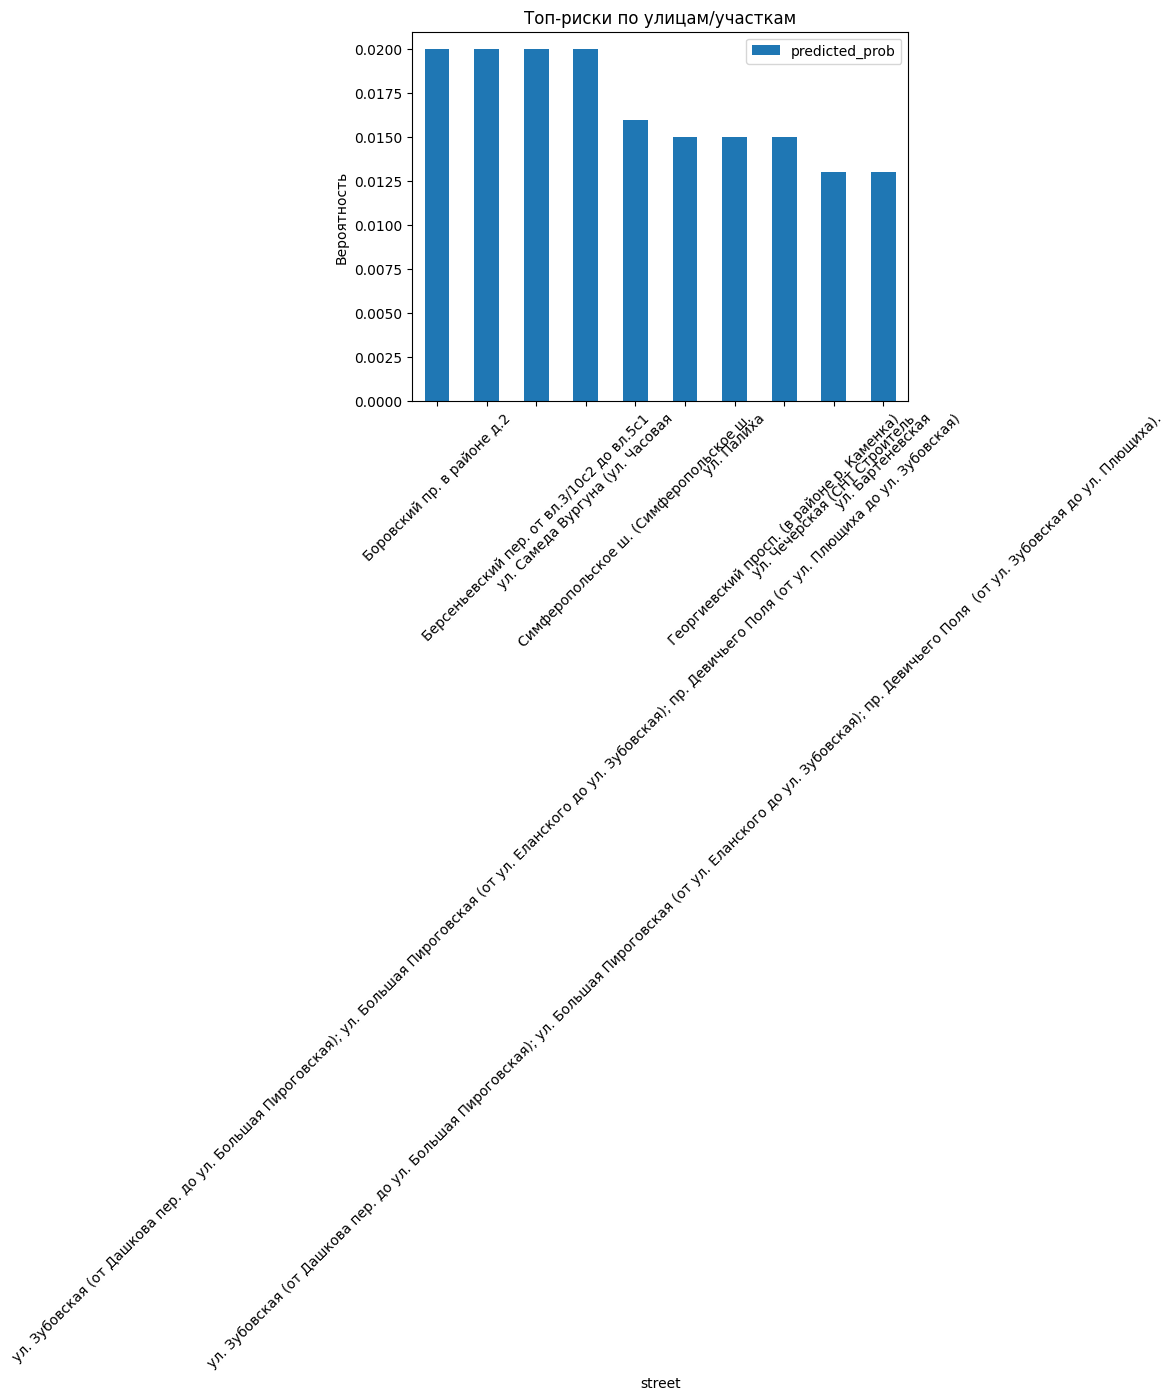

In [40]:
def predict_risk(model, full_df, next_week_date=pd.to_datetime('2026-10-21'), threshold=0.7):
    """Предсказания по участкам + возврат geom/address."""
    if 'prev_count' not in full_df.columns:
        raise ValueError("prev_count отсутствует!")
    
    last_df = full_df.groupby(['cluster_id', 'street']).last().reset_index()
    if last_df['prev_count'].isna().any():
        last_df['prev_count'] = last_df['prev_count'].fillna(0)
    
    last_df['high_prev'] = (last_df['prev_count'] > 1).astype(int)
    last_df['avg_closed_lines'] = last_df.get('avg_closed_lines', pd.Series(0, index=last_df.index)).fillna(0)
    last_df['low_speed_flag'] = last_df.get('low_speed_flag', pd.Series(0, index=last_df.index)).fillna(0)
    last_df['is_summer'] = int((next_week_date.month >= 6) & (next_week_date.month <= 9))
    last_df['cent_lon'] = last_df.get('cent_lon', pd.Series(37.6, index=last_df.index))
    last_df['cent_lat'] = last_df.get('cent_lat', pd.Series(55.75, index=last_df.index))
    
    X_pred = last_df[['prev_count', 'high_prev', 'avg_closed_lines', 'low_speed_flag', 'is_summer', 'cent_lon', 'cent_lat']]
    last_df['predicted_prob'] = model.predict_proba(X_pred)[:, 1]
    
    # Добавляем geom/address
    predictions = last_df[['cluster_id', 'street', 'predicted_prob', 'geom', 'address']].sort_values('predicted_prob', ascending=False).round(3)
    predictions['recommendation'] = np.where(predictions['predicted_prob'] > threshold, 'Обходить!', 'Проезжаем')
    
    print(f"\nПредсказания на {next_week_date.date()} (топ-10 по риску, с geom/address):")
    print(predictions.head(10))
    
    # График
    plt.figure(figsize=(12, 6))
    predictions.head(10).plot(x='street', y='predicted_prob', kind='bar')
    plt.title('Топ-риски по улицам/участкам')
    plt.ylabel('Вероятность')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predictions

if model:
    predictions = predict_risk(model, full_df)